In [ ]:
import sys
from utils.helper import preprocess_runs

path_name_dict = {
    'JOB-Light': 'JOB-light.json',
    'JOB': 'JOB.json',
    'JOB-Complex': 'JOB-Complex.json'
}
benchmark_stats_dict = preprocess_runs(json_path='workload_runs',path_name_dict=path_name_dict)

Loading run files from /PhD/ldb/ldb_data/runs/json
Benchmark: JOB-Light (140 plans)


Cleaning SQL: 100%|██████████| 140/140 [00:06<00:00, 22.99it/s]


Benchmark: JOB (37085 plans)


Cleaning SQL: 100%|██████████| 37085/37085 [00:11<00:00, 3274.01it/s] 


Benchmark: JOB-Complex (15805 plans)


Cleaning SQL: 100%|██████████| 15805/15805 [00:00<00:00, 23286.62it/s]


# Speedup Analysis: Postgres vs. Optimum

70
113
30
Benchmark      Num Queries    Total Opt Runtime (s)    Total PG Runtime (s)    Total Speedup    Median Speedup    Median Diff (s)    PG Best Plan Selected (%)    Speedup 90th percentile
-----------  -------------  -----------------------  ----------------------  ---------------  ----------------  -----------------  ---------------------------  -------------------------
JOB-Light               70                  2359.72                 2795.53             1.18           1.00208               0.51                        40                       1.45408
JOB                    113                   156.79                  312.23             1.99           1.28699              88                            8.85                    5.11035
JOB-Complex             30                    54.17                  567.01            10.47           8.50421           10654.2                          0                      83.6684


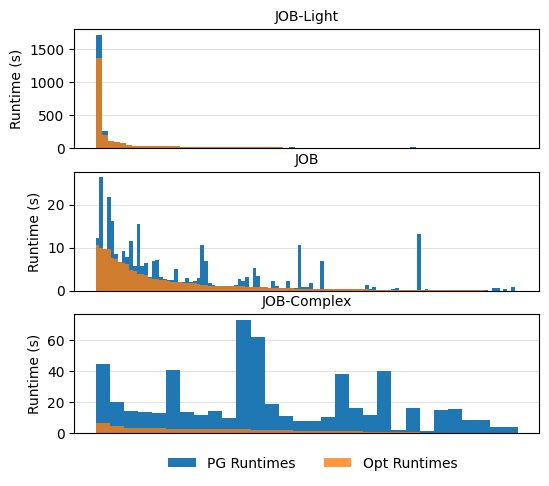

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


def create_runtime_plot(df, benchmark_name: str, max=None, ax=None, show_legend=True, bbox_to_anchor=None):
    opt_runtimes = df['optimal']
    pg_runtimes = df['pg']
    q_ids = df['q_id']

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    sorted_opt_runtimes = sorted(opt_runtimes, reverse=True)
    sorted_pg_runtimes = [x for _, x in sorted(zip(opt_runtimes, pg_runtimes), reverse=True)]
    sorted_qids = [str(x) for _, x in sorted(zip(opt_runtimes, q_ids), reverse=True)]

    ax.bar(sorted_qids, sorted_pg_runtimes, label='PG Runtimes', width=1)
    ax.bar(sorted_qids, sorted_opt_runtimes, label='Opt Runtimes', alpha=0.8, width=1)
    # plt.title(f'Opt / PG Runtimes ({benchmark_name})')
    if show_legend:
        ax.legend(frameon=False, loc='upper right', bbox_to_anchor=bbox_to_anchor, ncols=2)

    ax.set_title(f'{benchmark_name}', fontsize=10)
    ax.set_ylabel('Runtime (s)')

    # hide xtick labels
    ax.set_xticks([])

    if max is not None:
        ax.set_ylim(0, max)

    ax.grid(True, color='lightgrey', linewidth=0.7, alpha=0.7)
    ax.set_axisbelow(True)


fig, axs = plt.subplots(len(benchmark_stats_dict), 1, figsize=(6, 1.75 * len(benchmark_stats_dict)))

cleanup_pg_opt_mismatch = True

tabulate_list = []
id_to_sql_dict = defaultdict(dict)
for i, (benchmark_name, info) in enumerate(benchmark_stats_dict.items()):
    optimal_runtimes = []
    pg_runtimes = []
    q_ids = []
    speedup_list = []
    diff_list = []
    pg_best_plan_selected = []

    for id, (sql, plan_info) in enumerate(info.items()):
        opt_rt = plan_info['opt_runtime']
        pg_rt = plan_info['pg_runtime']

        if opt_rt is None or pg_rt is None:
            print(f'Skip because of null: {opt_rt} / {pg_rt}')
            continue

        # convert to seconds
        opt_rt = opt_rt / 1000
        pg_rt = pg_rt / 1000

        if cleanup_pg_opt_mismatch and opt_rt > pg_rt:
            opt_rt = pg_rt

        q_ids.append(id)
        optimal_runtimes.append(opt_rt)
        pg_runtimes.append(pg_rt)
        id_to_sql_dict[benchmark_name][id] = (sql, opt_rt, pg_rt, plan_info['opt_hint'])

        speedup_list.append(plan_info['pg_slowdown'])
        diff_list.append(plan_info['pg_opt_diff'])

        pg_best_plan_selected.append(opt_rt == pg_rt)

    # convert to df (two columns)
    df = pd.DataFrame({'optimal': optimal_runtimes, 'pg': pg_runtimes, 'q_id': q_ids,
                       'speedup': speedup_list, 'diff': diff_list})
    print(len(optimal_runtimes))

    # add to list
    tabulate_list.append([benchmark_name, len(info), f"{sum(df['optimal']):.2f}", f"{sum(df['pg']):.2f}",
                          f"{sum(df['pg']) / sum(df['optimal']):.2f}", f"{np.median(df['speedup'])}",
                          f"{np.median(df['diff']):.2f}",
                          f'{sum(pg_best_plan_selected) / len(pg_best_plan_selected) * 100:.2f}',
                          np.percentile(df['speedup'], 90)])

    create_runtime_plot(df, benchmark_name=benchmark_name, max=None, ax=axs[i], show_legend=i == 2,
                        bbox_to_anchor=(0.85, -.09))

import tabulate

print(tabulate.tabulate(tabulate_list,
                        headers=['Benchmark', 'Num Queries', 'Total Opt Runtime (s)', 'Total PG Runtime (s)',
                                 'Total Speedup', 'Median Speedup', 'Median Diff (s)', 'PG Best Plan Selected (%)',
                                 'Speedup 90th percentile']))

# save figure
plt.savefig('tmp/speedups.pdf', bbox_inches='tight', dpi=300, transparent=False)


In [3]:
id_to_sql_dict['JOB-Complex'][13]

("SELECT MIN(chn.name) AS character_name, MIN(mi_idx.info) AS rating, MIN(n.name) AS playing_actor, MIN(t.title) AS complete_hero_movie FROM complete_cast AS cc, comp_cast_type AS cct1, comp_cast_type AS cct2, char_name AS chn, cast_info AS ci, info_type AS it2, keyword AS k, kind_type AS kt, movie_info_idx AS mi_idx, movie_keyword AS mk, name AS n, title AS t, aka_name AS ak WHERE cct1.kind = 'cast' AND cct2.kind LIKE '%complete%' AND chn.name IS NOT NULL AND (chn.name LIKE '%man%' OR chn.name LIKE '%Man%') AND it2.info = 'rating' AND k.keyword IN ('superhero', 'marvel-comics', 'based-on-comic', 'tv-special', 'fight', 'violence', 'magnet', 'web', 'claw', 'laser') AND kt.kind = 'movie' AND mi_idx.info > '5.0' AND t.production_year > 2000 AND kt.id = t.kind_id AND t.id = mk.movie_id AND t.id = ci.movie_id AND t.id = cc.movie_id AND t.id = mi_idx.movie_id AND mk.movie_id = ci.movie_id AND mk.movie_id = cc.movie_id AND mk.movie_id = mi_idx.movie_id AND ci.movie_id = cc.movie_id AND ci.mov

In [4]:
sql = list(benchmark_stats_dict['JOB-Complex'].keys())

print(len(sql))

string = ''
for s in sql:
    string += f'{s}\n'

print(string)

30
SELECT MIN(n.name) AS member_in_charnamed_movie FROM cast_info AS ci, company_name AS cn, keyword AS k, movie_companies AS mc, movie_keyword AS mk, name AS n, title AS t, char_name AS cn2, aka_name AS ak WHERE k.keyword ='character-name-in-title' AND n.name LIKE '%Bert%' AND n.id = ci.person_id AND ci.movie_id = t.id AND t.id = mk.movie_id AND mk.keyword_id = k.id AND t.id = mc.movie_id AND mc.company_id = cn.id AND ci.movie_id = mc.movie_id AND ci.movie_id = mk.movie_id AND mc.movie_id = mk.movie_id AND ak.name_pcode_cf = cn2.name_pcode_nf AND ak.name_pcode_nf = n.name_pcode_cf AND ak.name_pcode_nf = cn2.surname_pcode AND ak.name_pcode_cf = cn.name_pcode_sf;
SELECT MIN(cn.name) AS company_name, MIN(lt.link) AS link_type, MIN(t.title) AS western_follow_up FROM company_name AS cn, company_type AS ct, keyword AS k, link_type AS lt, movie_companies AS mc, movie_info AS mi, movie_keyword AS mk, movie_link AS ml, title AS t WHERE cn.country_code !='[pl]' AND (cn.name LIKE '%Film%' OR cn.